In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os, requests, tarfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import zscore

# Dataset Preprocessing

For data preprocessing, we downloaded data from free, open platform (https://osf.io/r638s/download, https://osf.io/yqb3e/download, https://osf.io/ymnjv/download) and modified preprocessing code from open source code (https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/fMRI/load_kay_images.ipynb).

In [ ]:
# @title Download the data


fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

In [ ]:
dat.keys()

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])

In [ ]:
print(labels.shape)
print(val_labels.shape)

(4, 1750)
(4, 120)


In [ ]:
print(dat["roi_names"])
print(dat["roi"])
print(type(dat["responses"]))
print(dat['responses_test'].shape)

['Other' 'V1' 'V2' 'V3' 'V3A' 'V3B' 'V4' 'LatOcc']
[3 3 3 ... 3 3 6]
<class 'numpy.ndarray'>
(120, 8428)


In [ ]:
train = {'Other':[],  'V1':[],  'V2':[],  'V3':[],  'V3A':[],  'V3B':[],  'V4':[],  'LatOcc':[]}
test = {'Other':[],  'V1':[],  'V2':[],  'V3':[],  'V3A':[],  'V3B':[],  'V4':[],  'LatOcc':[]}
for i in range(len(dat['roi'])):
  roi_name = dat['roi_names'][dat['roi'][i]]
  train[roi_name].append(dat['responses'][:, i])
for i in train.keys():
  train[i] = np.array(train[i])
  train[i] = np.transpose(train[i])

for i in range(len(dat['roi'])):
  roi_name = dat['roi_names'][dat['roi'][i]]
  test[roi_name].append(dat['responses_test'][:, i])
for i in test.keys():
  test[i] = np.array(test[i])
  test[i] = np.transpose(test[i])

In [ ]:
for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
  print(test[i].shape)

(120, 1294)
(120, 2083)
(120, 1790)
(120, 484)
(120, 314)
(120, 1535)
(120, 928)


# Modeling

In [ ]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()

    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        )

    # Decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 2, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 2, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, 2, stride=2),
        nn.Sigmoid()
        )

  def forward(self, x):
    x = x.unsqueeze(1)
    # print(x.shape)
    x = self.encoder(x)
    # print(x.shape)
    x = self.decoder(x)
    # print(x.shape)
    return x

  def encoder_representation(self, x):
    x = x.unsqueeze(1)
    # print(x.shape)
    x = self.encoder(x)
    return x

# Train and Test

In [ ]:
loss_fn = nn.MSELoss()
learning_rate=0.0005
batch_size=100
momentum=.99
n_epochs = 25
stimuli_train = torch.Tensor(dat['stimuli'])
loss_models = []
model_1 = ConvAutoencoder()
model_2 = ConvAutoencoder()
model_3 = ConvAutoencoder()
model_4 = ConvAutoencoder()
model_5 = ConvAutoencoder()
models = [model_1, model_2, model_3, model_4, model_5]

for j in range(0, 5):
  optimizer = optim.SGD(models[j].parameters(), lr=learning_rate, momentum=momentum)
  loss_list = []
  for i in range(n_epochs):
    ishuffle = torch.randperm(stimuli_train.shape[0])  # random ordering of training data
    # print(ishuffle)
    minibatch_data = torch.split(stimuli_train[ishuffle], batch_size)  # split train_data into minibatches
    for images in minibatch_data:
      output = models[j](images).squeeze()
      # print(images.shape)
      # print(output.shape)
      loss = loss_fn(images, output)
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      # print(loss)
      loss_list.append(loss.item())
  loss_models.append(loss_list)
  print(i+1,"train_end")
loss_models = np.array(loss_models)

25 train_end
25 train_end
25 train_end
25 train_end
25 train_end


Text(0, 0.5, 'Loss')

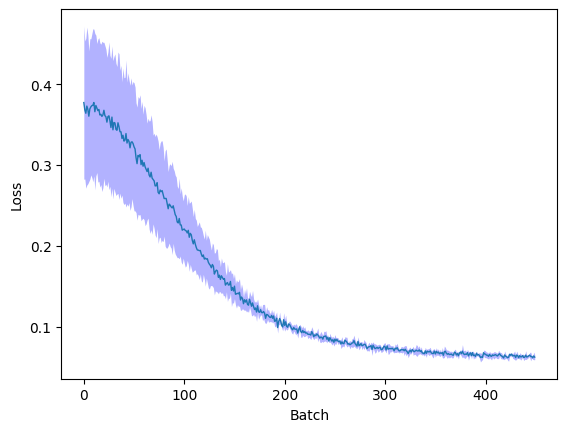

In [ ]:
mean_values = np.mean(loss_models, axis = 0)
std_values = np.std(loss_models, axis = 0)

a = [i for i in range(len(mean_values))]
plt.plot(a, mean_values, linewidth = 1)
plt.fill_between(a,mean_values - std_values,mean_values + std_values,alpha=0.3,
                linewidth=0,edgecolor='lightblue',
                 facecolor='blue',antialiased=True)
plt.xlabel("Batch")
plt.ylabel("Loss")

# Representational Similarity Analysis (RSA)

For RSA and plot functions of correlation, we used and made some modification of Neuromatch code (https://compneuro.neuromatch.io/tutorials/W1D5_DeepLearning/student/W1D5_Tutorial3.html).

In [ ]:
def construct_rdm_autoencoder(model, stimuli):
  # minibatch_data = torch.split(stimuli_train, batch_size)
  output = model.encoder_representation(stimuli)
  rdm = np.zeros([stimuli.shape[0], stimuli.shape[0]])
  for i in range(0, stimuli.shape[0]):
    for j in range(0, stimuli.shape[0]):
      x = torch.flatten(output[i])
      y = torch.flatten(output[j])
      mean_x = torch.mean(x)
      mean_y = torch.mean(y)
      numerator = torch.sum((x - mean_x) * (y - mean_y)).item()
      denominator = torch.sqrt(torch.sum((x - mean_x)**2) * torch.sum((y - mean_y)**2)).item()
      dissimilarity = 1 - numerator / denominator
      rdm[i][j] = dissimilarity
  rdm = rdm/max(map(max, rdm))
  return rdm

def plot_corr_matrix(rdm, ax=None, show=False):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing

  """
  if ax is None:
    ax = plt.gca()
  image = ax.imshow(rdm, vmin=0.0, vmax=2.0)
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(image, ax=ax, label='dissimilarity')
  if show:
    plt.show()

def plot_multiple_rdm(rdm_dict):
  """Draw multiple subplots for each RDM in rdm_dict."""
  fig, axs = plt.subplots(1, len(rdm_dict),
                          figsize=(4 * len(rdm_dict), 3.5))

  # Compute RDM's for each set of responses and plot
  for i, (label, rdm) in enumerate(rdm_dict.items()):

    image = plot_corr_matrix(rdm, axs[i])
    axs[i].set_title(label)
  plt.show()

def correlate_rdms(rdm1, rdm2):
  """Correlate off-diagonal elements of two RDM's

  Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
      correlate with rdm1

  Returns:
    float: correlation coefficient between the off-diagonal elements
      of rdm1 and rdm2

  """

  # Extract off-diagonal elements of each RDM
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]

  corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]

  return corr_coef

def plot_rdm_rdm_correlations_1(rdm_sim, correlation_matrix):
  mean = np.mean(correlation_matrix, axis = 0)
  stdev = np.std(correlation_matrix, axis = 0)
  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(rdm_sim.keys(), rdm_sim.values(), yerr=stdev, capsize = 5)

  ax.set_xlabel('ROI')
  ax.set_ylabel('Correlation of model layer RDM\nwith ROIs')
  plt.show()

def plot_rdm_rdm_correlations(rdm_sim):

  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(rdm_sim.keys(), rdm_sim.values())
  ax.set_xlabel('ROI')
  ax.set_ylabel('Correlation of model layer RDM\nwith ROIs')
  plt.show()

def plot_comparison_correlations(correlation_matrix1, correlation_matrix2):
  mean1 = np.mean(correlation_matrix1, axis = 0)
  stdev1 = np.std(correlation_matrix1, axis = 0)
  mean2 = np.mean(correlation_matrix2, axis = 0)
  stdev2 = np.std(correlation_matrix2, axis = 0)
  a = np.array([i+1 for i in range(len(rdm_sim.keys()))])
  bar_width = 0.35
  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(a - bar_width/2, mean1, width = bar_width, yerr=stdev1, label="before")
  ax.bar(a + bar_width/2, mean2, width = bar_width, yerr=stdev2, label="after")
  ax.set_xticklabels(['', 'V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"])
  ax.set_xlabel('ROI')
  ax.set_ylabel('Correlation of model layer RDM\nwith ROIs')
  ax.legend()
  plt.show()

In [ ]:
#train dataset
rdm_train = []
for j in range(0, 5):
  rdm_train.append(construct_rdm_autoencoder(models[j], stimuli_train))

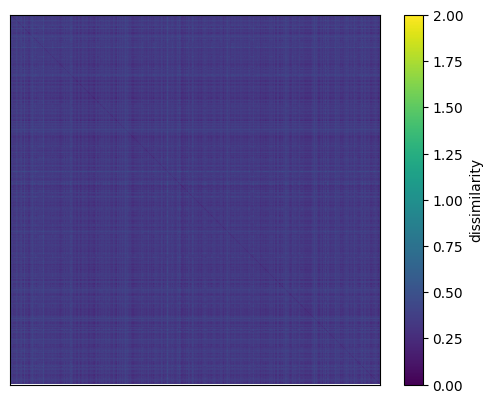

In [ ]:
plot_corr_matrix(rdm_train[0])

In [ ]:
# rdm_train_dict = {}
# for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
#   rdm_roi = np.ones([train[i].shape[0], train[i].shape[0]]) - train[i]@train[i].T
#   rdm_train_dict[i] = rdm_roi
#   print(rdm_roi.shape)
# plot_multiple_rdm(rdm_train_dict)

1294
(1750, 1750)
2083
(1750, 1750)
1790
(1750, 1750)
484
(1750, 1750)
314
(1750, 1750)
1535
(1750, 1750)
928
(1750, 1750)


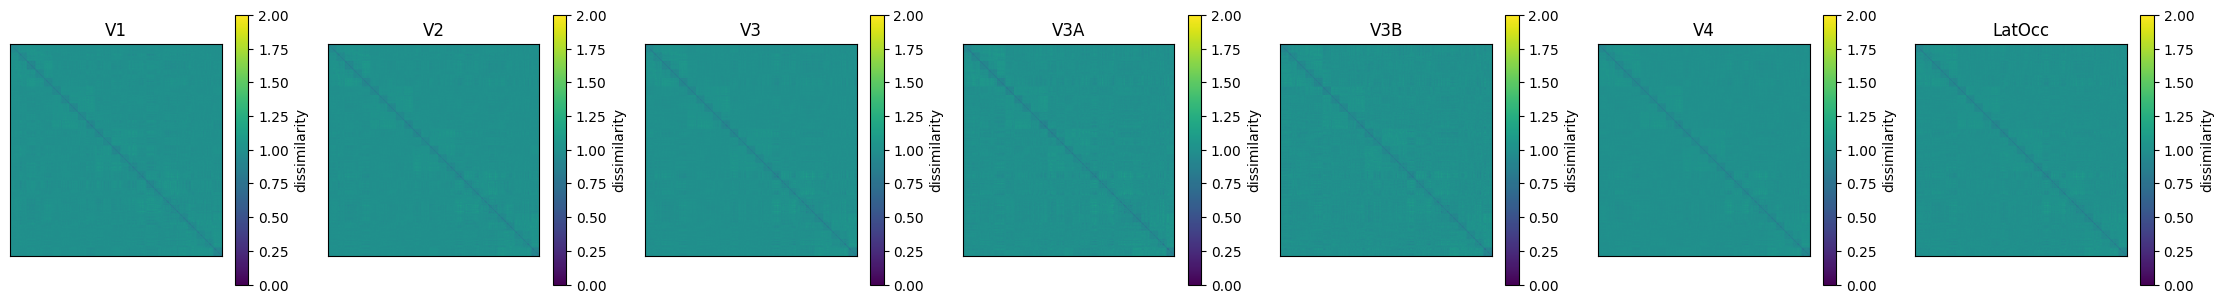

In [ ]:
## 수정

rdm_train_dict = {}
for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
  zresp = zscore(train[i], axis=1)
  print(zresp.shape[1])
  rdm_roi = 1 - zresp@zresp.T/zresp.shape[1]
  rdm_train_dict[i] = rdm_roi
  print(rdm_roi.shape)
plot_multiple_rdm(rdm_train_dict)

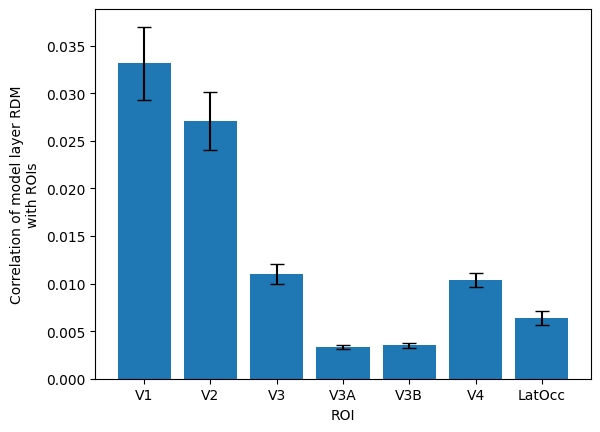

In [ ]:
rdm_sim = {'V1':0, 'V2':0, "V3":0, "V3A":0, "V3B":0, "V4":0, "LatOcc":0}
correlation_matrix_train = []
for j in range(0, 5):
  corr = []
  for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
    corr.append(correlate_rdms(rdm_train[j], rdm_train_dict[i]))
    rdm_sim[i] = ((rdm_sim[i] * j) + correlate_rdms(rdm_train[j], rdm_train_dict[i])) / (j+1)
  correlation_matrix_train.append(corr)
correlation_matrix_train = np.array(correlation_matrix_train)
plot_rdm_rdm_correlations_1(rdm_sim, correlation_matrix_train)

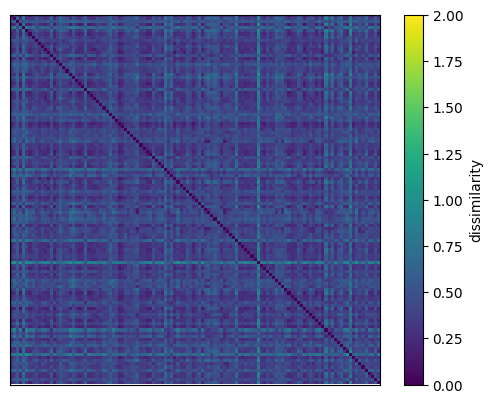

In [ ]:
#test dataset
stimuli_test = torch.Tensor(dat['stimuli_test'])
rdm_test = []
for j in range(0, 5):
  rdm_test.append(construct_rdm_autoencoder(models[j], stimuli_test))
plot_corr_matrix(rdm_test[0])

In [ ]:
# rdm_test_dict = {}
# for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
#   rdm_roi = np.ones([test[i].shape[0], test[i].shape[0]]) - test[i]@test[i].T
#   rdm_test_dict[i] = rdm_roi
#   print(rdm_roi.shape)

# # plot_multiple_rdm(rdm_test_dict)


1294
(120, 120)
2083
(120, 120)
1790
(120, 120)
484
(120, 120)
314
(120, 120)
1535
(120, 120)
928
(120, 120)


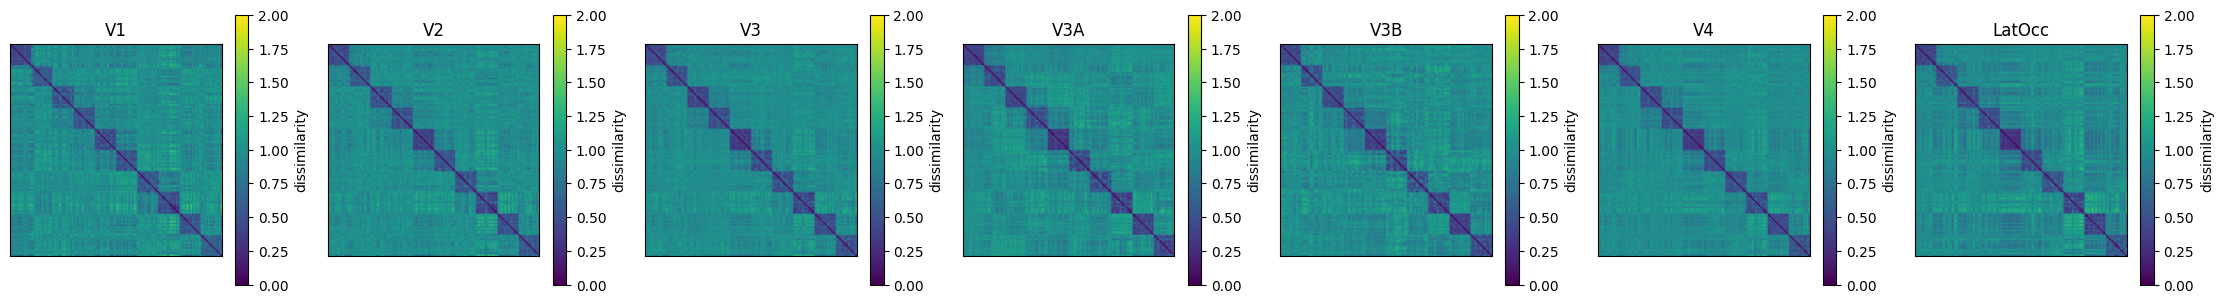

In [ ]:
rdm_test_dict = {}
for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
  zresp = zscore(test[i], axis=1)
  print(zresp.shape[1])
  rdm_roi = 1 - zresp@zresp.T/zresp.shape[1]
  rdm_test_dict[i] = rdm_roi
  print(rdm_roi.shape)
plot_multiple_rdm(rdm_test_dict)

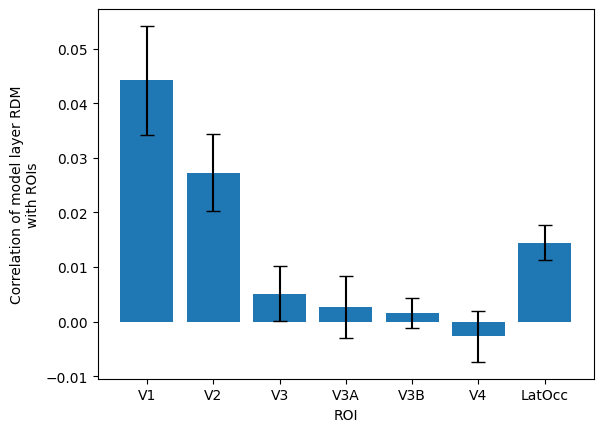

In [ ]:
# Split RDMs into V1 responses and model responses
rdm_test_sim = {'V1':0, 'V2':0, "V3":0, "V3A":0, "V3B":0, "V4":0, "LatOcc":0}
correlation_matrix_test = []
for j in range(0, 5):
  corr = []
  for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
    corr.append(correlate_rdms(rdm_test[j], rdm_test_dict[i]))
    rdm_test_sim[i] = ((rdm_test_sim[i] * j) + correlate_rdms(rdm_test[j], rdm_test_dict[i])) / (j+1)
  correlation_matrix_test.append(corr)
correlation_matrix_test = np.array(correlation_matrix_test)
plot_rdm_rdm_correlations_1(rdm_test_sim, correlation_matrix_test)

# PCA

In [ ]:
# rdm_train_dict = {}
# for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
#   rdm_roi = np.ones([train[i].shape[0], train[i].shape[0]]) - train[i]@train[i].T
#   rdm_train_dict[i] = rdm_roi
#   print(rdm_roi.shape)
# plot_multiple_rdm(rdm_train_dict)

In [ ]:
for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
  print(i, train[i].shape)

V1 (1750, 1294)
V2 (1750, 2083)
V3 (1750, 1790)
V3A (1750, 484)
V3B (1750, 314)
V4 (1750, 1535)
LatOcc (1750, 928)


In [ ]:
train_pca = dict()
# pca_100 = PCA(n_components=100)

# for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
#   pca_100.fit(train[i])
#   train_pca[i] = pca_100.transform(train[i])

pca_train = PCA(n_components=0.9)
for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
  pca_train.fit(train[i])
  train_pca[i] = pca_train.transform(train[i])
  print(i, train[i].shape)
  print(pca_train.explained_variance_.shape)
  print(pca_train.explained_variance_.shape[0] / min(train[i].shape[0], train[i].shape[1]))

V1 (1750, 1294)
(497,)
0.384080370942813
V2 (1750, 2083)
(635,)
0.3628571428571429
V3 (1750, 1790)
(621,)
0.35485714285714287
V3A (1750, 484)
(273,)
0.5640495867768595
V3B (1750, 314)
(201,)
0.6401273885350318
V4 (1750, 1535)
(629,)
0.40977198697068407
LatOcc (1750, 928)
(461,)
0.49676724137931033


In [ ]:
test_pca = dict()
# pca_100 = PCA(n_components=100)

# for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
#   pca_100.fit(train[i])
#   train_pca[i] = pca_100.transform(train[i])

pca_test = PCA(n_components=0.9)
for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
  pca_test.fit(test[i])
  test_pca[i] = pca_train.transform(train[i])
  print(i, train[i].shape)
  print(pca_train.explained_variance_.shape)
  print(pca_train.explained_variance_.shape[0] / min(train[i].shape[0], train[i].shape[1]))

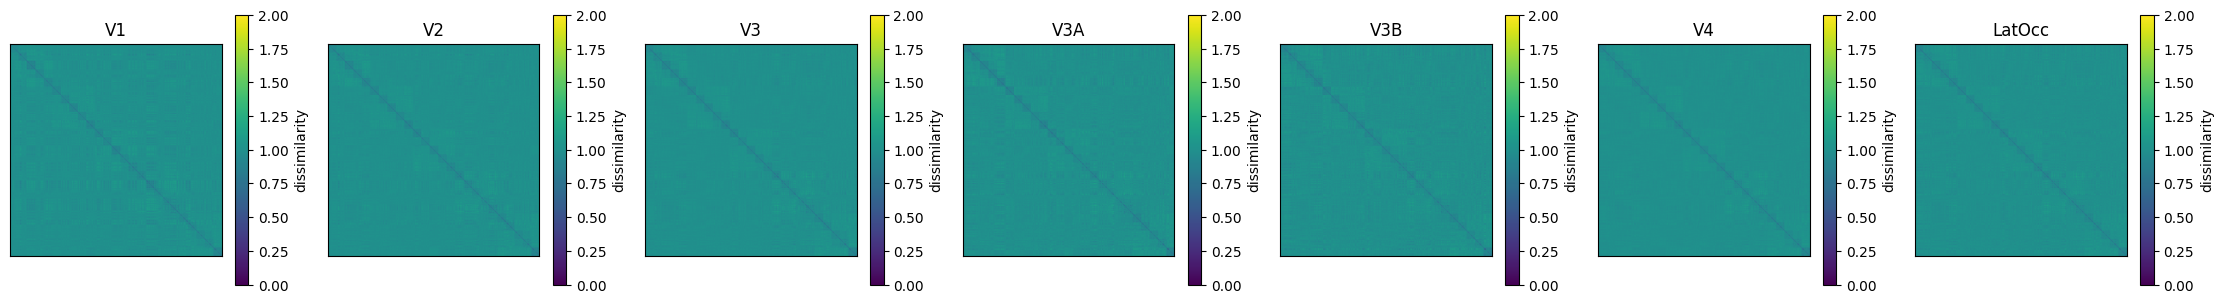

In [ ]:
rdm_train_pca_dict = {}
for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
  zresp = zscore(train_pca[i], axis=1)
  # print(zresp.shape[1])
  rdm_roi = 1 - zresp@zresp.T/zresp.shape[1]
  rdm_train_pca_dict[i] = rdm_roi
plot_multiple_rdm(rdm_train_pca_dict)

{'V1': 0.683893903435591, 'V2': 0.7119711464166059, 'V3': 0.7157725564780337, 'V3A': 0.6628800059645604, 'V3B': 0.6344596608550909, 'V4': 0.7497912410440046, 'LatOcc': 0.7432961902541636}


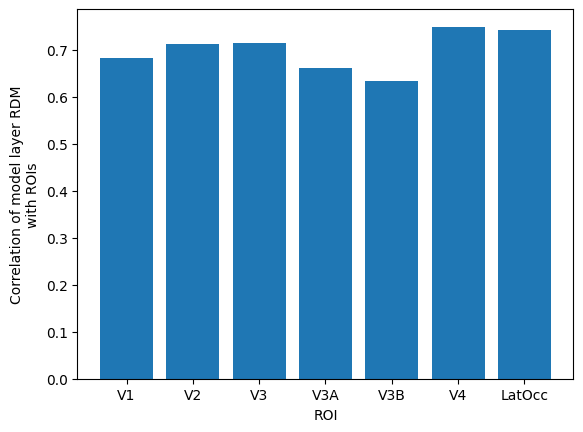

In [ ]:
rdm_train_difference = {i: correlate_rdms(rdm_train_dict[i], rdm_train_pca_dict[i]) for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]}

print(rdm_train_sim)
plot_rdm_rdm_correlations(rdm_train_sim)

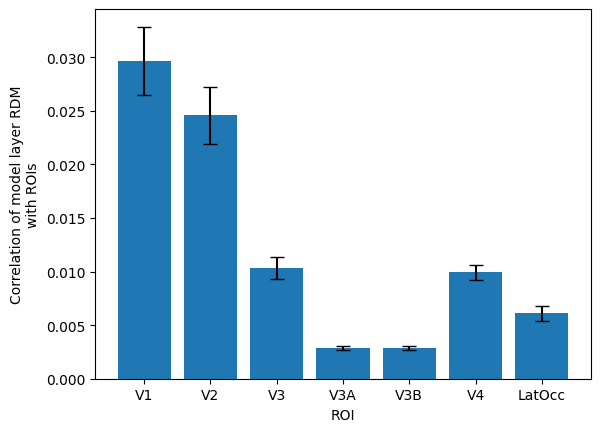

/tmp/ipykernel_956/1132597113.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"])


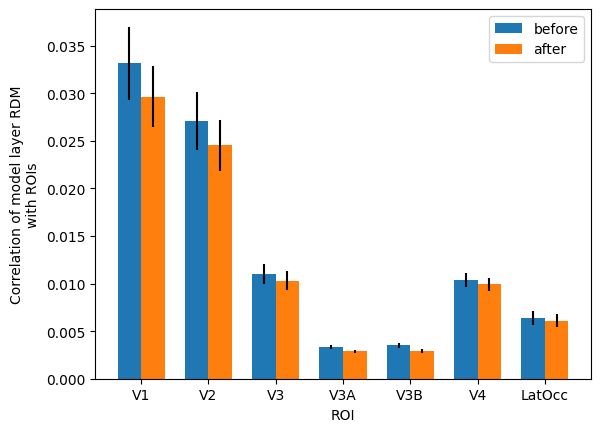

In [ ]:
rdm_train_pca_sim = {'V1':0, 'V2':0, "V3":0, "V3A":0, "V3B":0, "V4":0, "LatOcc":0}
correlation_matrix_train_pca = []
for j in range(0, 5):
  corr = []
  for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
    corr.append(correlate_rdms(rdm_train[j], rdm_train_pca_dict[i]))
    rdm_train_pca_sim[i] = ((rdm_train_pca_sim[i] * j) + correlate_rdms(rdm_train[j], rdm_train_pca_dict[i])) / (j+1)
  correlation_matrix_train_pca.append(corr)
correlation_matrix_train_pca = np.array(correlation_matrix_train_pca)
plot_rdm_rdm_correlations_1(rdm_train_pca_sim, correlation_matrix_train_pca)



# rdm_sim = {'V1':0, 'V2':0, "V3":0, "V3A":0, "V3B":0, "V4":0, "LatOcc":0}
# correlation_matrix_train = []
# for j in range(0, 5):
#   corr = []
#   for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
#     corr.append(correlate_rdms(rdm_train[j], rdm_train_dict[i]))
#     rdm_sim[i] = ((rdm_sim[i] * j) + correlate_rdms(rdm_train[j], rdm_train_dict[i])) / (j+1)
#   correlation_matrix_train.append(corr)
# correlation_matrix_train = np.array(correlation_matrix_train)
# plot_rdm_rdm_correlations_1(rdm_sim, correlation_matrix_train)
plot_comparison_correlations(correlation_matrix_train, correlation_matrix_train_pca)

In [ ]:
test_pca = dict()
# pca_100 = PCA(n_components=100)

# for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
#   pca_100.fit(test[i])
#   test_pca[i] = pca_100.transform(test[i])

pca_test = PCA(n_components=0.9)
for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
  pca_test.fit(test[i])
  test_pca[i] = pca_test.transform(test[i])
  print(i, test[i].shape)
  print(pca_test.explained_variance_.shape)
  print(pca_test.explained_variance_.shape[0] / min(test[i].shape[0], test[i].shape[1]))

V1 (120, 1294)
(59,)
0.49166666666666664
V2 (120, 2083)
(62,)
0.5166666666666667
V3 (120, 1790)
(65,)
0.5416666666666666
V3A (120, 484)
(53,)
0.44166666666666665
V3B (120, 314)
(51,)
0.425
V4 (120, 1535)
(69,)
0.575
LatOcc (120, 928)
(63,)
0.525


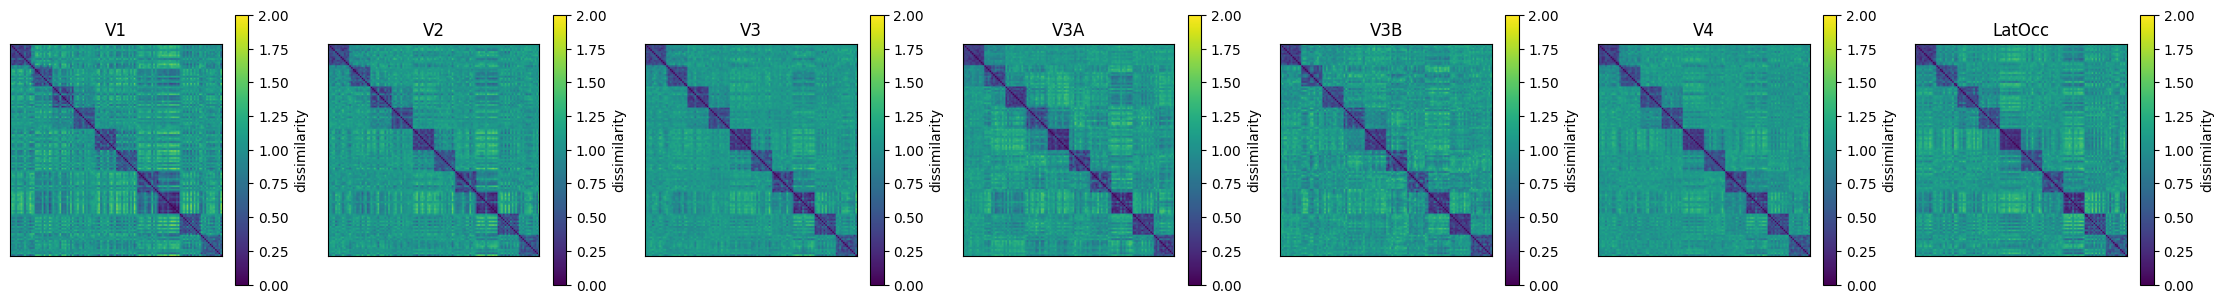

In [ ]:
rdm_test_pca_dict = {}
for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
  zresp = zscore(test_pca[i], axis=1)
  # print(zresp.shape[1])
  rdm_roi = 1 - zresp@zresp.T/zresp.shape[1]
  rdm_test_pca_dict[i] = rdm_roi
plot_multiple_rdm(rdm_test_pca_dict)

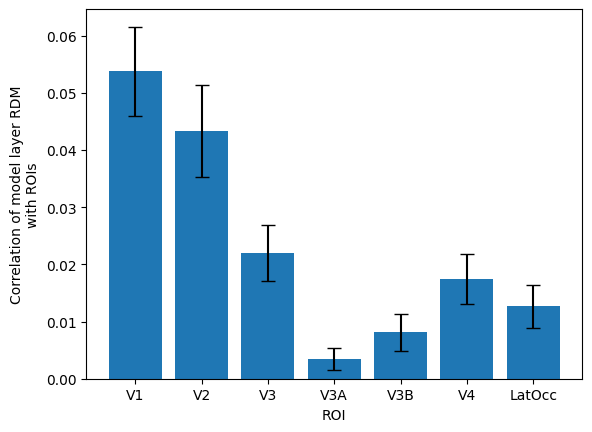

/tmp/ipykernel_956/1132597113.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"])


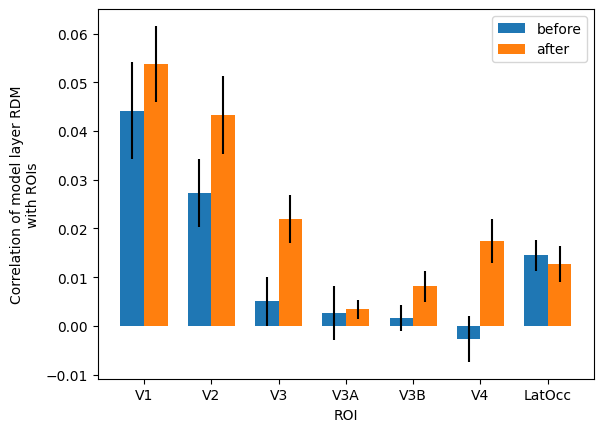

In [ ]:
rdm_test_pca_sim = {'V1':0, 'V2':0, "V3":0, "V3A":0, "V3B":0, "V4":0, "LatOcc":0}
correlation_matrix_test_pca = []
for j in range(0, 5):
  corr = []
  for i in ['V1', 'V2', "V3", "V3A", "V3B", "V4", "LatOcc"]:
    corr.append(correlate_rdms(rdm_test[j], rdm_test_pca_dict[i]))
    rdm_test_pca_sim[i] = ((rdm_test_pca_sim[i] * j) + correlate_rdms(rdm_test[j], rdm_test_pca_dict[i])) / (j+1)
  correlation_matrix_test_pca.append(corr)
correlation_matrix_test_pca = np.array(correlation_matrix_test_pca)
plot_rdm_rdm_correlations_1(rdm_test_pca_sim, correlation_matrix_test_pca)
plot_comparison_correlations(correlation_matrix_test, correlation_matrix_test_pca)